## Install and import scCASE and the dependencies.

scCASE is available on PyPI and can be installed via

In [1]:
#pip install scCASE 

You can also install scCASE from GitHub via

In [2]:
# git clone git://github.com/BioX-NKU/scCASE.git
# cd scCASE
# python setup.py install

The following packages are used in this tutorial.

In [3]:
import scCASE
import pandas as pd
import episcanpy as epi
import anndata as ad
import sklearn.metrics
import warnings
warnings.filterwarnings("ignore")

## Check data

Load the AnnData object of n_obs × n_vars count matrix (Or csv/txt format which rows correspond to cells and columns to peaks).

In [4]:
adata = epi.read("/home/sccasimp/data/sccasimp/BM0828/origdata.h5ad")

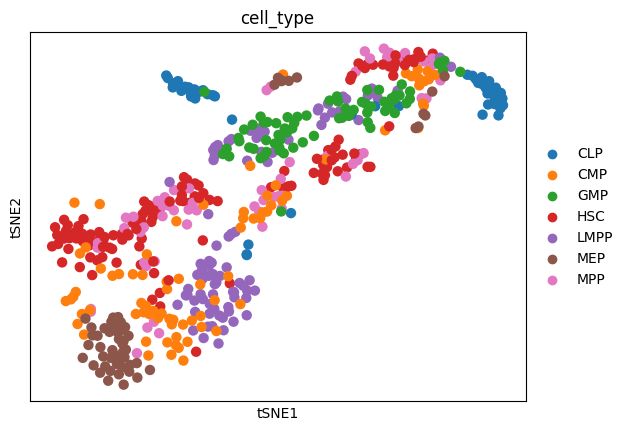

In [6]:
epi.pp.pca(adata)
epi.tl.tsne(adata)
epi.pl.tsne(adata,color = ["cell_type"])

2023-12-30 11:28:33.937582: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-30 11:28:33.986633: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-30 11:28:33.986680: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-30 11:28:33.986718: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-30 11:28:33.998738: I tensorflow/core/platform/cpu_feature_g

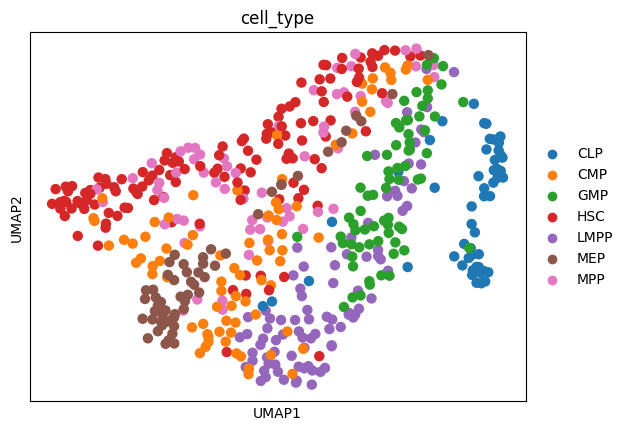

In [7]:
epi.pp.pca(adata)
epi.pp.neighbors(adata)
epi.tl.umap(adata)
epi.pl.umap(adata,color = ["cell_type"])

## Run scCASE

scCASE is used to enhance scCAS data, and function "scCASE.run" is the main function of scCASE. The essential parameter of scCASE is data_path, and method name.

In [8]:
data_imputed = scCASE.run(adata,data_format="h5ad",method= "scCASE")
#OR scCASE.run("/home/sccasimp/data/sccasimp/BM0828/origdata.h5ad",data_format="h5ad",method= "scCASE")
#OR scCASE.run("BM0828.txt",data_format="csv",data_sep = "\t") !csv/txt format which rows correspond to cells and columns to peaks

Data shape after feature selection:
(99662, 533)
Raw dataset shape:  (533, 99662)
Dataset shape after preprocessing:  (533, 92229)
Estimating by sum of squared distances...
Estimating by Davies-Bouldin score...
Estimating by silhouette coefficient...
Initializing...
Generating similarity matrix...
Updating...
Finished


The parameter K has a significant impact on scCASE. By default, we use EpiAster to estimate the value of K. You can estimate K and run scCASE separately. A K value slightly more than the number of cell types of concern, can achieve better enhancement.

In [9]:
Estimate_K = scCASE.Estimate_k(adata.X.T.A,search_range=range(5,15),method = "scCASE")

Raw dataset shape:  (533, 320083)
Dataset shape after preprocessing:  (533, 92229)
Estimating by sum of squared distances...
Estimating by Davies-Bouldin score...
Estimating by silhouette coefficient...


In [10]:
data_imputed = scCASE.run(adata,data_format="h5ad",method= "scCASE",K=Estimate_K)

Data shape after feature selection:
(99662, 533)
Initializing...
Generating similarity matrix...
Updating...
Finished


Output of scCASE is an ad.AnnData, imputed data is saved in "X", cell embeding is saved in obsm["Embeding"], projection matrix is saved in varm["Projection"], and the similarity matrix is saved in obsp[Similarity].

In [11]:
data_imputed

AnnData object with n_obs × n_vars = 533 × 99662
    obs: 'cell_type'
    var: 'peak'
    obsm: 'Embeding'
    varm: 'Projection'
    obsp: 'Similarity'

## Analysis

### Visualization

scCASE improves the analyses of scCAS data, including visualization, clustering and idenficiation of cell type-specific peaks. Function "scCASE.lazy()" including TF-IDF, PCA, creating neighbors graph,and t-SNE/UMAP.

In [12]:
scCASE.lazy(data_imputed)

In [13]:
scCASE.lazy(adata)

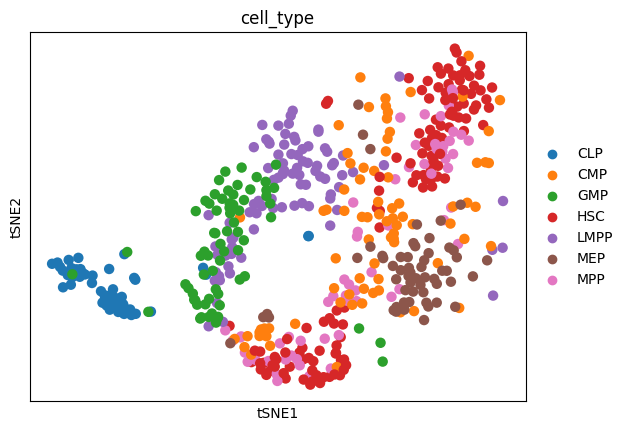

In [14]:
epi.pl.tsne(adata,color = ["cell_type"])

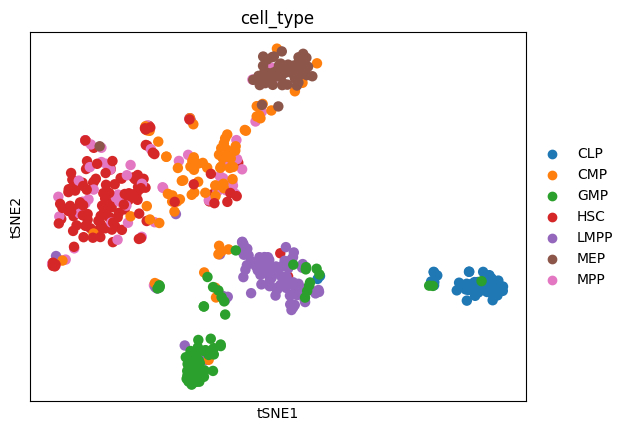

In [15]:
epi.pl.tsne(data_imputed,color = ["cell_type"])

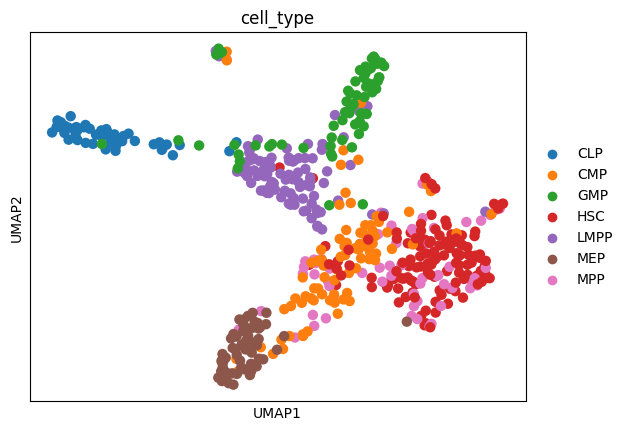

In [16]:
epi.pl.umap(data_imputed,color = ["cell_type"])

### Clustering

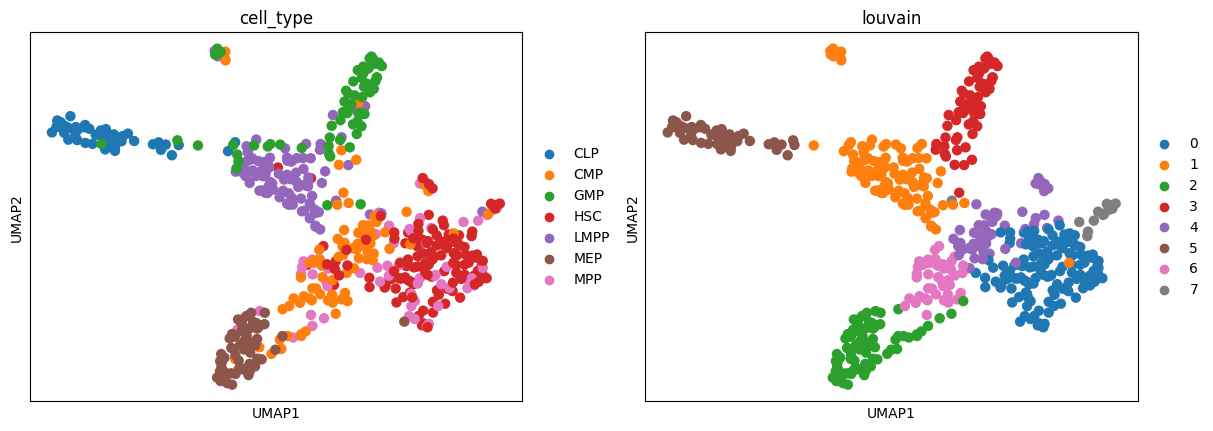

In [17]:
epi.tl.louvain(data_imputed)
epi.pl.umap(data_imputed,color = ["cell_type","louvain"])

Specify the number of clusters through binary division

step 0
got 11 at resolution 1.5
step 1
got 8 at resolution 0.75
step 2
got 6 at resolution 0.375
step 3
got 7 at resolution 0.5625


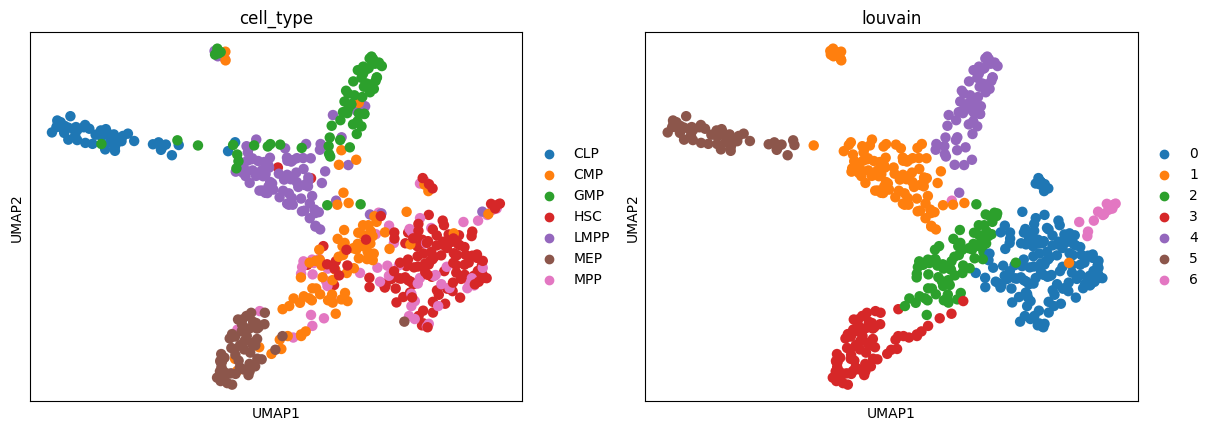

In [18]:
epi.tl.getNClusters(data_imputed,method = "louvain",n_cluster = 7)
epi.pl.umap(data_imputed,color = ["cell_type","louvain"])

In [19]:
sklearn.metrics.adjusted_rand_score(data_imputed.obs["cell_type"],data_imputed.obs["louvain"])

0.529107781083356

### Identify specific peaks

In [20]:
Cell_embedding = ad.AnnData(data_imputed.obsm["Embeding"])
Cell_embedding.obs = data_imputed.obs

{'heatmap_ax': <Axes: >, 'groupby_ax': <Axes: xlabel='cell_type'>}

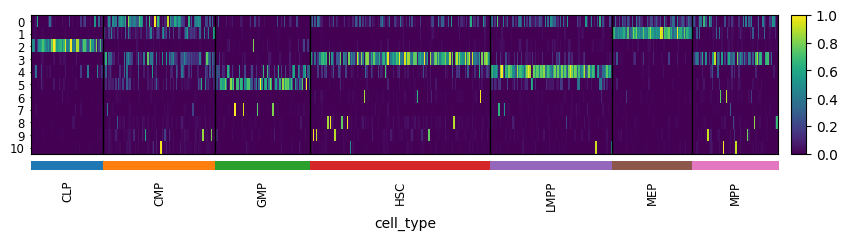

In [21]:
epi.pl.heatmap(Cell_embedding, Cell_embedding.var_names, groupby='cell_type', standard_scale="var",swap_axes=True,show = False)

In [29]:
data_imputed

AnnData object with n_obs × n_vars = 533 × 99662
    obs: 'cell_type'
    var: 'peak'
    obsp: 'Similarity'

Utilize "scCASE.identify_specific_peaks" to identify specific peaks for a cluster/cell type.

In [24]:
peaks = scCASE.identify_specific_peaks(data_imputed,obs = "cell_type",type_ = "HSC",peak_name = "peak")

In [25]:
peaks.head()

,Value
chr2_174924170_174924670,1.000000
chr9_80210255_80210755,0.907077
chr6_135644238_135644738,0.899901
chr10_35668126_35668626,0.888349
chr16_73430488_73430988,0.887635


## Run scCASER

Run scCASER use function "scCASE.run" with parameter:method="scCASER"

In [26]:
data_imputed = scCASE.run("/home/sccasimp/data/sccasimp/BM0828/origdata.h5ad","/home/sccasimp/data/sccasimp/BM0828/bulk.csv",data_format="h5ad",method="scCASER")

Data shape after feature selection:
(99662, 533)
Reference shape after feature selection:
(99662, 17)
Raw dataset shape:  (533, 99662)
Dataset shape after preprocessing:  (533, 92229)
Estimating by sum of squared distances...
Estimating by Davies-Bouldin score...
Estimating by silhouette coefficient...
Initializing...
m = 17
n = 533
q = 99662
Generating similarity matrix...
Updating...
Finished


In [30]:
scCASE.lazy(data_imputed)

step 0
got 12 at resolution 1.5
step 1
got 8 at resolution 0.75
step 2
got 6 at resolution 0.375
step 3
got 6 at resolution 0.5625
step 4
got 8 at resolution 0.65625
step 5
got 8 at resolution 0.609375
step 6
got 6 at resolution 0.5859375
step 7
got 7 at resolution 0.59765625


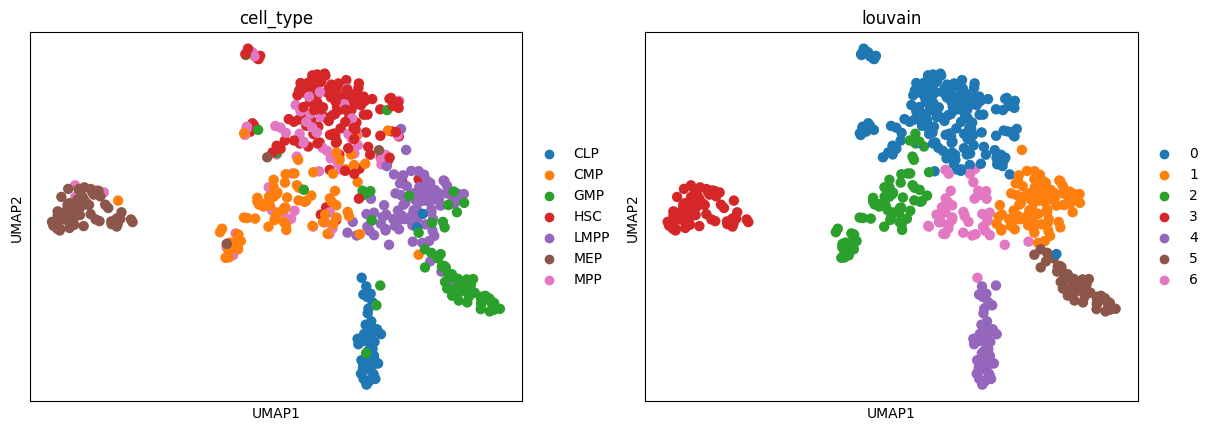

In [31]:
epi.tl.getNClusters(data_imputed,method = "louvain",n_cluster = 7)
epi.pl.umap(data_imputed,color = ["cell_type","louvain"])

In [33]:
ARI = sklearn.metrics.adjusted_rand_score(data_imputed.obs["cell_type"],data_imputed.obs["louvain"])
print(f"ARI={ARI}")

ARI=0.5415301040298295
